In [1]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm 
import sys

sys.path.append('/private/groups/shapirolab/brock/Software')
from py3_functions import *

from IPython.display import display

!mkdir -p /private/groups/shapirolab/brock/mutation
os.chdir('/private/groups/shapirolab/brock/mutation')
!mkdir -p cmds logs

### R stuff
from rpy2 import rinterface
#from jupyter_helpers import rpy2_autocompletion
%load_ext rpy2.ipython

samples = []
with open('poplists/samples.txt') as infile:
    for line in infile:
        line = line.strip()
        samples.append(line)
infile.close()

In [3]:
%%R
library(data.table)
library(tidyverse)
library(magrittr)
library(ggplot2)
library(patchwork)

# Get input vcfs

In [4]:
x = pd.read_csv('poplists/families.txt',sep="\t")
fam_2_samples = x.groupby('famName')['sampleName'].apply(list).to_dict()
sample_2_ped = x.groupby('sampleName')['Relationship'].apply(list).to_dict()

## I'll be comparing the variants identified via 
## 1) GATK ('vcfs' folder)
## 2) bcftools ('bcftools' folder)
sources = {'./vcfs/biallelic.vcf.gz':'./est',
           './bcftools/biallelic.vcf.gz':'./bcftools/est/'}
for INVCF, OUTDIR in sources.items():
    !mkdir -p $OUTDIR
    for FAMILY, SAMPLELIST in fam_2_samples.items():
        parentstring = ''
        for SAMPLE in SAMPLELIST:
            status = sample_2_ped[SAMPLE][0]
            if status == 'Parent':
                parentstring += f"{SAMPLE},"
        for SAMPLE in SAMPLELIST:
            status = sample_2_ped[SAMPLE][0]
            if status == 'Child':
                cmd = ( # Take only variants that are segregating in the relevant trio, no missing data
                        '''bcftools view -v snps -i 'F_MISSING=0.0' --min-ac 1:minor --max-ac 1:minor -s {parentstring}{SAMPLE} {INVCF} | ''' 
                        # Make sure the child (third genotype, base 0) is a het, phased or not
                        '''bcftools view -i 'GT[2]="0/1" | GT[2]="1/0" | GT[2]="0|1" | GT[2]="1|0"' | '''
                        # Does it fall within callable regions?
                        '''vcftools --vcf - --bed masks/{FAMILY}_positive_REPINCLUDED_mask.bed --recode --recode-INFO-all --stdout | ''' # Is it in callable regions?
                        # Cleanup
                        '''bgzip -c > {OUTDIR}/{SAMPLE}.singleton.vcf.gz && tabix {OUTDIR}/{SAMPLE}.singleton.vcf.gz\n''').format(FAMILY = FAMILY, parentstring = parentstring, SAMPLE = SAMPLE, INVCF = INVCF, OUTDIR = OUTDIR)
                slurm = make_slurm(run = False, echo = False, id = f"{SAMPLE}.2vcf", cmd_string = cmd, mem = '1000',time = '01:00:00', p = 'long')

# Filtering & estimation

Above we identified heterozygous sites in children where both parents were homozygous ref. Now we do **more filtering**

1. GQ > 60 all individuals

3. Candidate mutations must not be present in any reads from either parent
4. Candidate mutations must not be present in any other samples (except siblings)
5. Candidate mutations must not have low allelic depth in the offspring

## GATK calls

In [23]:
%%R
rel = fread('poplists/families.txt')
samples = rel %>% filter(Relationship == 'Child') %>% pull(sampleName)

var_dfs = list()
for (SAMPLE in samples){
    vcfpath = paste0('est/',SAMPLE,'.singleton.vcf.gz')
    print(vcfpath)
    vars = fread(cmd = (paste0('bgzip -dc ',vcfpath,' | grep -v "#"')),sep="\t") %>% dplyr::select(!V8)
    cols = fread(cmd = (paste0('bgzip -dc ',vcfpath,' | grep "#CHROM" | sed "s/#//g"')),sep="\t") %>% dplyr::select(!INFO)
    vars %<>% set_colnames(colnames(cols)) %>% mutate(UNIQ = paste0(CHROM,'_',POS))
    vars %<>%
    separate_longer_delim(.,-c(CHROM, POS, ID, REF, ALT, QUAL, FILTER, UNIQ), delim = ":") %>% 
    pivot_longer(-c(CHROM, POS, ID, REF, ALT, QUAL, FILTER, FORMAT, UNIQ))
    vars %<>% left_join(., 
                        rel %>% dplyr::select(sampleName,Relationship) %>% unique, 
                        by = c('name' = 'sampleName'))
    var_dfs[[SAMPLE]] = vars
}


candidates = list()
for (SAMPLE in samples){
    print(SAMPLE)
    input = var_dfs[[SAMPLE]]
    #print(head(input))

    ## The below section takes care of allelic bias and presence of alternate allele reads (however few) in parents
    AD_fail =
        var_dfs[[SAMPLE]] %>% 
        filter(FORMAT == 'AD') %>%
        separate_wider_delim(.,value, names = c('ref','alt'), delim=',') %>% 
        mutate(across(c('ref', 'alt'), ~as.numeric(.))) %>%
        mutate(freq = pmin(alt,ref)/(ref + alt)) %>%
        mutate(ADPASS = ifelse((name == SAMPLE & freq < 0.30),0,1)) %>%
        mutate(ADPASS = ifelse((Relationship == 'Parent' & freq != 0.00),0,ADPASS))
    
    AD_pass_sites = 
        AD_fail %>% 
        group_by(UNIQ) %>%
        summarize(ADPASS = sum(ADPASS)) %>%
        ungroup %>% 
        dplyr::select(UNIQ, ADPASS)
    
    ## This is simple genotype quality
    GQ_pass_sites = 
        var_dfs[[SAMPLE]] %>%
        filter(FORMAT == 'GQ') %>%
        mutate(value = as.numeric(value)) %>%
        mutate(GQPASS = ifelse(value <= 60,0,1)) %>%
        group_by(UNIQ) %>%
        summarize(GQPASS = sum(GQPASS)) %>%
        ungroup %>% 
        #filter(GQPASS == 3) %>%
        dplyr::select(UNIQ,GQPASS) 
    
    
    ## DP
    DP_pass_sites =
        var_dfs[[SAMPLE]] %>%
        filter(FORMAT == 'DP') %>%
        mutate(value = as.numeric(value)) %>%
        mutate(DPPASS = ifelse(value < 10,0,1)) %>%
        group_by(UNIQ) %>%
        summarize(DPPASS = sum(DPPASS)) %>%
        ungroup %>% 
        dplyr::select(UNIQ,DPPASS)
    
    
    ## 
    final =
        var_dfs[[SAMPLE]] %>% 
        left_join(.,AD_pass_sites) %>%
        left_join(.,GQ_pass_sites) %>%
        left_join(.,DP_pass_sites) %>%
        mutate(start = POS - 1, end = POS) %>%
        filter(name == SAMPLE, FORMAT == 'AD') %>%
        dplyr::select(CHROM, start, end, REF, ALT, name, value, ADPASS, GQPASS, DPPASS) %>%
        filter(ADPASS == 3, GQPASS ==3, DPPASS == 3) %>% 
        group_by(CHROM) %>%
        mutate(d_last = start - lag(end), d_next = lead(start)- end) %>%
        ungroup %>%
        filter(is.na(d_next)|d_next > 200) %>%
        filter(is.na(d_last)|d_last > 200)
    
    candidates[[SAMPLE]] = final %>% mutate(sample = SAMPLE)
    fwrite(final %>% 
           dplyr::select(CHROM,start,end,REF,ALT,value, d_last, d_next), 
                            paste0('est/',SAMPLE,'_candidates.bed'), sep = "\t", col.names = FALSE, na='NA', quote = F)
    
}

candidates = bind_rows(candidates)

[1] "est/FG29.singleton.vcf.gz"
[1] "est/FG30.singleton.vcf.gz"
[1] "est/FG33.singleton.vcf.gz"
[1] "est/NorbertW853.singleton.vcf.gz"
[1] "est/NorbertW740.singleton.vcf.gz"
[1] "est/NorbertW756.singleton.vcf.gz"
[1] "est/NorbertW802.singleton.vcf.gz"
[1] "est/ToothlessL824.singleton.vcf.gz"
[1] "est/ToothlessL960.singleton.vcf.gz"
[1] "FG29"
Joining with `by = join_by(UNIQ)`
Joining with `by = join_by(UNIQ)`
Joining with `by = join_by(UNIQ)`
[1] "FG30"
Joining with `by = join_by(UNIQ)`
Joining with `by = join_by(UNIQ)`
Joining with `by = join_by(UNIQ)`
[1] "FG33"
Joining with `by = join_by(UNIQ)`
Joining with `by = join_by(UNIQ)`
Joining with `by = join_by(UNIQ)`
[1] "NorbertW853"
Joining with `by = join_by(UNIQ)`
Joining with `by = join_by(UNIQ)`
Joining with `by = join_by(UNIQ)`
[1] "NorbertW740"
Joining with `by = join_by(UNIQ)`
Joining with `by = join_by(UNIQ)`
Joining with `by = join_by(UNIQ)`
[1] "NorbertW756"
Joining with `by = join_by(UNIQ)`
Joining with `by = join_by(UNIQ)`
J

In [24]:
%%R
candidates %>%
    group_by(CHROM,end) %>% 
    summarize(count = n()) %>%
    arrange(desc(count))

`summarise()` has grouped output by 'CHROM'. You can override using the
`.groups` argument.
# A tibble: 2,391 × 3
# Groups:   CHROM [18]
   CHROM                end count
   <chr>              <int> <int>
 1 HiC_scaffold_10 48095344     5
 2 HiC_scaffold_16 10365509     5
 3 HiC_scaffold_5   7489985     5
 4 HiC_scaffold_6  30066215     5
 5 HiC_scaffold_1  43444738     4
 6 HiC_scaffold_12  6043046     4
 7 HiC_scaffold_14 30143822     4
 8 HiC_scaffold_15 44734311     4
 9 HiC_scaffold_18  7933185     4
10 HiC_scaffold_2  58657682     4
# ℹ 2,381 more rows
# ℹ Use `print(n = ...)` to see more rows


## Bcftools calls

Read in and combine with GATK calls above

In [25]:
%%R
rel = fread('poplists/families.txt')
samples = rel %>% filter(Relationship == 'Child') %>% pull(sampleName)

var_dfs = list()
for (SAMPLE in samples){
    vcfpath = paste0('bcftools/est/',SAMPLE,'.singleton.vcf.gz')
    print(vcfpath)
    vars = fread(cmd = (paste0('bgzip -dc ',vcfpath,' | grep -v "#"')),sep="\t") %>% dplyr::select(!V8)
    cols = fread(cmd = (paste0('bgzip -dc ',vcfpath,' | grep "#CHROM" | sed "s/#//g"')),sep="\t") %>% dplyr::select(!INFO)
    vars %<>% set_colnames(colnames(cols)) %>% mutate(UNIQ = paste0(CHROM,'_',POS))
    vars %<>%
    separate_longer_delim(.,-c(CHROM, POS, ID, REF, ALT, QUAL, FILTER, UNIQ), delim = ":") %>% 
    pivot_longer(-c(CHROM, POS, ID, REF, ALT, QUAL, FILTER, FORMAT, UNIQ))
    vars %<>% left_join(., 
                        rel %>% dplyr::select(sampleName,Relationship) %>% unique, 
                        by = c('name' = 'sampleName'))
    var_dfs[[SAMPLE]] = vars
}

bcf_candidates = list()
for (SAMPLE in samples){
    print(SAMPLE)
    input = var_dfs[[SAMPLE]]

    ## The below section takes care of allelic bias and presence of alternate allele reads (however few) in parents
    AD_fail =
        var_dfs[[SAMPLE]] %>% 
        filter(FORMAT == 'AD') %>%
        separate_wider_delim(.,value, names = c('ref','alt'), delim=',') %>% 
        mutate(across(c('ref', 'alt'), ~as.numeric(.))) %>%
        mutate(freq = pmin(alt,ref)/(ref + alt)) %>%
        mutate(ADPASS = ifelse((name == SAMPLE & freq < 0.30),0,1)) %>%
        mutate(ADPASS = ifelse((Relationship == 'Parent' & freq != 0.00),0,ADPASS))
    
    AD_pass_sites = 
        AD_fail %>% 
        group_by(UNIQ) %>%
        summarize(ADPASS = sum(ADPASS)) %>%
        ungroup %>% 
        dplyr::select(UNIQ, ADPASS)
    
    ### This is simple genotype quality
    ### NO GQ FIELD AVAILABLE HERE
    #GQ_pass_sites = 
    #    var_dfs[[SAMPLE]] %>%
    #    filter(FORMAT == 'GQ') %>%
    #    mutate(value = as.numeric(value)) %>%
    #    mutate(GQPASS = ifelse(value <= 60,0,1)) %>%
    #    group_by(UNIQ) %>%
    #    summarize(GQPASS = sum(GQPASS)) %>%
    #    ungroup %>% 
    #    #filter(GQPASS == 3) %>%
    #    dplyr::select(UNIQ,GQPASS) 
    
    
    ## DP
    DP_pass_sites =
        var_dfs[[SAMPLE]] %>%
        filter(FORMAT == 'DP') %>%
        mutate(value = as.numeric(value)) %>%
        mutate(DPPASS = ifelse(value < 10,0,1)) %>%
        group_by(UNIQ) %>%
        summarize(DPPASS = sum(DPPASS)) %>%
        ungroup %>% 
        dplyr::select(UNIQ,DPPASS)
    
    
    ## 
    final =
        var_dfs[[SAMPLE]] %>% 
        left_join(.,AD_pass_sites) %>%
        #left_join(.,GQ_pass_sites) %>%
        left_join(.,DP_pass_sites) %>%
        mutate(start = POS - 1, end = POS) %>%
        filter(name == SAMPLE, FORMAT == 'AD') %>%
        dplyr::select(CHROM, start, end, REF, ALT, name, value, ADPASS, DPPASS) %>%
        filter(ADPASS == 3, DPPASS == 3) %>% 
        group_by(CHROM) %>%
        mutate(d_last = start - lag(end), d_next = lead(start)- end) %>%
        ungroup %>%
        filter(is.na(d_next)|d_next > 200) %>%
        filter(is.na(d_last)|d_last > 200)
    
    bcf_candidates[[SAMPLE]] = final %>% mutate(sample = SAMPLE)
    fwrite(final %>% 
           dplyr::select(CHROM,start,end,REF,ALT,value, d_last, d_next), 
                            paste0('bcftools/est/',SAMPLE,'_candidates.bed'), sep = "\t", col.names = FALSE, na='NA', quote = F)
    
}

bcf_candidates = bind_rows(bcf_candidates)

[1] "bcftools/est/FG29.singleton.vcf.gz"
[1] "bcftools/est/FG30.singleton.vcf.gz"
[1] "bcftools/est/FG33.singleton.vcf.gz"
[1] "bcftools/est/NorbertW853.singleton.vcf.gz"
[1] "bcftools/est/NorbertW740.singleton.vcf.gz"
[1] "bcftools/est/NorbertW756.singleton.vcf.gz"
[1] "bcftools/est/NorbertW802.singleton.vcf.gz"
[1] "bcftools/est/ToothlessL824.singleton.vcf.gz"
[1] "bcftools/est/ToothlessL960.singleton.vcf.gz"
[1] "FG29"
Joining with `by = join_by(UNIQ)`
Joining with `by = join_by(UNIQ)`
[1] "FG30"
Joining with `by = join_by(UNIQ)`
Joining with `by = join_by(UNIQ)`
[1] "FG33"
Joining with `by = join_by(UNIQ)`
Joining with `by = join_by(UNIQ)`
[1] "NorbertW853"
Joining with `by = join_by(UNIQ)`
Joining with `by = join_by(UNIQ)`
[1] "NorbertW740"
Joining with `by = join_by(UNIQ)`
Joining with `by = join_by(UNIQ)`
[1] "NorbertW756"
Joining with `by = join_by(UNIQ)`
Joining with `by = join_by(UNIQ)`
[1] "NorbertW802"
Joining with `by = join_by(UNIQ)`
Joining with `by = join_by(UNIQ)`
[1] 

Merge GATK and bcftools below

In [26]:
%%R
combined = 
    full_join(
        candidates %>% dplyr::select(CHROM,start,end,REF,ALT,sample) %>% mutate(GATK = 1),
        bcf_candidates %>% dplyr::select(CHROM,start,end,REF,ALT, sample) %>% mutate(bcftools = 1),
        by = c('CHROM','start','end','sample','REF','ALT')) %>%
    mutate(GATK = ifelse(is.na(GATK),0,GATK), bcftools = ifelse(is.na(bcftools),0,bcftools))

combined %>% 
filter(GATK == 1, bcftools == 1) %>%
print(n = Inf)

# A tibble: 126 × 8
    CHROM              start      end REF   ALT   sample         GATK bcftools
    <chr>              <dbl>    <int> <chr> <chr> <chr>         <dbl>    <dbl>
  1 HiC_scaffold_2  20345372 20345373 A     G     FG29              1        1
  2 HiC_scaffold_2  67338091 67338092 T     A     FG29              1        1
  3 HiC_scaffold_2  71549310 71549311 G     A     FG29              1        1
  4 HiC_scaffold_3  28123510 28123511 C     A     FG29              1        1
  5 HiC_scaffold_3  31079938 31079939 G     C     FG29              1        1
  6 HiC_scaffold_4  10968218 10968219 C     G     FG29              1        1
  7 HiC_scaffold_5  17481102 17481103 T     G     FG29              1        1
  8 HiC_scaffold_5  34285238 34285239 G     T     FG29              1        1
  9 HiC_scaffold_5  56747004 56747005 C     T     FG29              1        1
 10 HiC_scaffold_6  20837340 20837341 C     G     FG29              1        1
 11 HiC_scaffold_7  33841068 338

## Sanity checks

What types of variants aren't found by both GATK and bcftools?

In [27]:
%%R
combined %>%
    filter(GATK == 1, bcftools == 0) %>% 
    sample_n(10) %>%
    dplyr::select(CHROM,start,end) %>%
    fwrite('misc/gatk_1_bcftools_0.bed',col.names = F, sep = "\t")

combined %>%
    filter(GATK == 0, bcftools == 1) %>% 
    sample_n(10) %>%
    dplyr::select(CHROM,start,end) %>%
    fwrite('misc/gatk_0_bcftools_1.bed',col.names = F, sep = "\t")

Take these regions and extract the bams to look at them in IGV

In [46]:
%%bash
bedtools sort -i misc/gatk_1_bcftools_0.bed | bedtools slop -b 150 -g white_abalone.genome | bedtools merge -i stdin > misc/gatk_1_bcftools_0_m150.bed
bedtools sort -i misc/gatk_0_bcftools_1.bed | bedtools slop -b 150 -g white_abalone.genome | bedtools merge -i stdin > misc/gatk_0_bcftools_1_m150.bed

In [8]:
!mkdir -p misc/sanity/
for SAMPLE in samples:
        if SAMPLE in ['NorbertW756','NorbertW802','Y121']:
            bam = f"aln/{SAMPLE}.combined.mdup.bam"
        else:
            bam = f"aln/{SAMPLE}.mdup.bam"

        cmd = ('''samtools view -@ 4 -L <(cat misc/*m150.bed) '''
               '''{bam} -b > misc/sanity/{SAMPLE}_candidates.bam && samtools index misc/sanity/{SAMPLE}_candidates.bam\n''').format(SAMPLE = SAMPLE, bam = bam)
        slurm = make_slurm(run = False, echo = False, id = f"{SAMPLE}_extract",cmd_string = cmd, mem = '20000', time = '04:00:00', c = 4, p = 'long')

A lot of these calls that are found in one and not the other indeed look iffy in IGV 

## Calculate raw rates

In [28]:
%%R
call_chroms = fread('call_chroms.txt')
gsize = sum(call_chroms$V2)
pos = 
    fread('masks/Fam1_positive_REPINCLUDED_mask.bed') %>% 
    set_colnames(c('chrom','start','end')) %>% 
    mutate(size = end - start + 1) %>%
    filter(chrom %in% call_chroms$V1)
Fam1Size = (sum(pos$size))

pos = 
    fread('masks/Fam2_positive_REPINCLUDED_mask.bed') %>% 
    set_colnames(c('chrom','start','end')) %>% 
    mutate(size = end - start + 1) %>%
    filter(chrom %in% call_chroms$V1)
Fam2Size = (sum(pos$size))


pos = 
    fread('masks/Fam3_positive_REPINCLUDED_mask.bed') %>% 
    set_colnames(c('chrom','start','end')) %>% 
    mutate(size = end - start + 1) %>%
    filter(chrom %in% call_chroms$V1)
Fam3Size = (sum(pos$size))

denom_sizes = data.frame(famName = c('Fam1','Fam2','Fam3'),size = c(Fam1Size,Fam2Size,Fam3Size))


####

rel = fread('poplists/families.txt')
fi = 
    combined %>% 
    filter(GATK == 1, bcftools == 1) %>%
    left_join(.,rel %>% dplyr::select(sampleName,famName),by = c('sample' = 'sampleName')) %>%
    left_join(.,denom_sizes)

fi %>%
    group_by(sample) %>%
    summarize(count = n(),famName = unique(famName), size = unique(size)) %>%
    mutate(rawrate = count/(2*size))

Joining with `by = join_by(famName)`
# A tibble: 9 × 5
  sample        count famName      size       rawrate
  <chr>         <int> <chr>       <dbl>         <dbl>
1 FG29             23 Fam1    891434842 0.0000000129 
2 FG30             11 Fam1    891434842 0.00000000617
3 FG33             19 Fam1    891434842 0.0000000107 
4 NorbertW740      10 Fam2    898249068 0.00000000557
5 NorbertW756      13 Fam2    898249068 0.00000000724
6 NorbertW802      16 Fam2    898249068 0.00000000891
7 NorbertW853      17 Fam2    898249068 0.00000000946
8 ToothlessL824     6 Fam3    917622025 0.00000000327
9 ToothlessL960    11 Fam3    917622025 0.00000000599


New mean

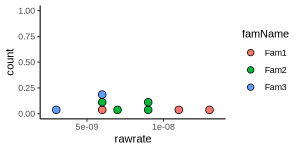

In [31]:
%%R -w 300 -h 150
input_df = 
    fi %>%
    group_by(sample) %>%
    summarize(count = n(),famName = unique(famName), size = unique(size)) %>%
    mutate(rawrate = count/(2*size))
ggplot(input_df,aes(x = rawrate, fill = famName)) +
    geom_dotplot(binwidth=1e-09, dotsize = 0.5,method = 'histodot',stackgroups = TRUE) +
    theme_classic()

In [35]:
%%R
mean(input_df$rawrate)

[1] 7.795798e-09


In [19]:
%%R
for (SAMPLE in samples){
    fwrite(combined %>% filter(GATK == 1, bcftools == 1, sample == SAMPLE) %>% dplyr::select(CHROM,start,end,REF,ALT),
            paste0('final/',SAMPLE,'_candidates.bed'),
            sep="\t", col.names = F)
}

In [20]:
%%bash
ls final/*candidates*bed | while read FILE;do
    SAMPLE=$(basename $FILE | sed "s/_candidates.bed//g")
    sed "s/^/$SAMPLE\t/g" $FILE
done > final/all_sample_by_candidates.txt

## Identify sib mutations

In [36]:
%%R
repeated = 
    fi %>%
    group_by(CHROM,end) %>%
    summarize(count = n()) %>% 
    arrange(desc(count)) %>%
    ungroup %>%
    filter(count > 1)
dfs = list()

for (I in seq(1,nrow(repeated),1)){
    a = repeated[I,"CHROM"] %>% pull(CHROM)
    b = repeated[I,"end"] %>% pull(end)
    dfs[[I]] = fi %>% filter(CHROM == a, end == b)
}
summ = bind_rows(dfs)

`summarise()` has grouped output by 'CHROM'. You can override using the
`.groups` argument.


Write out results

## False negatives and false positives

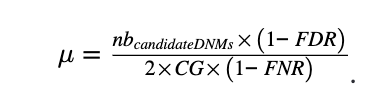

### FNR

How many true heterozygotes would get removed by my filters?

First, for the denominator I need to obtain how many hets I should have based on the parental genotypes.<br>
For true comparability, I need to remove things that aren't retained by both **bcftools & GATK**

In [11]:
!mkdir -p fnr

## Set up info
x = pd.read_csv('poplists/families.txt',sep="\t")
fam_2_samples = x.groupby('famName')['sampleName'].apply(list).to_dict()
sample_2_ped = x.groupby('sampleName')['Relationship'].apply(list).to_dict()

sources = {'./vcfs/biallelic.vcf.gz':'GATK',
           './bcftools/biallelic.vcf.gz':'bcftools'}

## Loop through families, properly ID parents and children
for FAMILY, SAMPLELIST in fam_2_samples.items():
    parentstring = ''
    for SAMPLE in SAMPLELIST:
        status = sample_2_ped[SAMPLE][0]
        if status == 'Parent':
            parentstring += f"{SAMPLE},"
    for SAMPLE in SAMPLELIST:
        status = sample_2_ped[SAMPLE][0]
        if status == 'Child':
            PT = re.sub(',.*$','',parentstring)

            ## Loop through GATK and bcftools input
            for INVCF, PREF in sources.items():
                ## Get perfectly het samples
                cmd = ( # For a family, the allele count should be EXACTLY 3, so I filter on this
                        '''bcftools view --min-ac 3:minor --max-ac 3:minor -s {parentstring}{SAMPLE} {INVCF} | '''
                        # Make sure parent 1 is homozygous for something
                        '''bcftools view -i 'GT[0]="0/0" | GT[0]="1/1"' | '''
                        # Make sure parent 2 is homozygous for something
                        '''bcftools view -i 'GT[1]="0/0" | GT[1]="1/1"' | '''
                        # Now apply masks
                        '''vcftools --vcf - --bed masks/{FAMILY}_positive_REPINCLUDED_mask.bed --recode --recode-INFO-all --stdout | '''
                        # Tidy up
                        '''bgzip -f -c > fnr/{SAMPLE}_{PREF}_true_hets.vcf.gz && tabix -f fnr/{SAMPLE}_{PREF}_true_hets.vcf.gz\n''').format(parentstring = parentstring, FAMILY = FAMILY, SAMPLE = SAMPLE, PREF = PREF, INVCF = INVCF)
                slurm = make_slurm(run = False, echo = False, id = f"{SAMPLE}_{PREF}.hets", cmd_string = cmd, mem = '1000',time = '01:00:00', p = 'long')
            

Now read in vcfs and get counts. This takes longer because these vcfs are larger

In [12]:
%%R
rel = fread('poplists/families.txt')
samples = rel %>% filter(Relationship == 'Child') %>% pull(sampleName)

het_dfs = list()
idx = 0
for (SAMPLE in samples){
    for (SOURCE in c('GATK','bcftools')){
        idx = idx + 1
        vcfpath = paste0('fnr/',SAMPLE,'_',SOURCE,'_true_hets.vcf.gz')
        print(vcfpath)
        vars = fread(cmd = (paste0('bgzip -dc ',vcfpath,' | grep -v "#"')),sep="\t") %>% dplyr::select(!V8)
        cols = fread(cmd = (paste0('bgzip -dc ',vcfpath,' | grep "#CHROM" | sed "s/#//g"')),sep="\t") %>% dplyr::select(!INFO)
        vars %<>% set_colnames(colnames(cols)) %>% mutate(UNIQ = paste0(CHROM,'_',POS))
        vars %<>%
        separate_longer_delim(.,-c(CHROM, POS, ID, REF, ALT, QUAL, FILTER, UNIQ), delim = ":") %>% 
        pivot_longer(-c(CHROM, POS, ID, REF, ALT, QUAL, FILTER, FORMAT, UNIQ))
        vars %<>% left_join(., 
                            rel %>% dplyr::select(sampleName,Relationship) %>% unique, 
                            by = c('name' = 'sampleName'))
        het_dfs[[idx]] = vars %>% mutate(sample = SAMPLE, source = SOURCE)
    }

}
hets = bind_rows(het_dfs)

[1] "fnr/FG29_GATK_true_hets.vcf.gz"
[1] "fnr/FG29_bcftools_true_hets.vcf.gz"
[1] "fnr/FG30_GATK_true_hets.vcf.gz"
[1] "fnr/FG30_bcftools_true_hets.vcf.gz"
[1] "fnr/FG33_GATK_true_hets.vcf.gz"
[1] "fnr/FG33_bcftools_true_hets.vcf.gz"
[1] "fnr/NorbertW853_GATK_true_hets.vcf.gz"
[1] "fnr/NorbertW853_bcftools_true_hets.vcf.gz"
[1] "fnr/NorbertW740_GATK_true_hets.vcf.gz"
[1] "fnr/NorbertW740_bcftools_true_hets.vcf.gz"
[1] "fnr/NorbertW756_GATK_true_hets.vcf.gz"
[1] "fnr/NorbertW756_bcftools_true_hets.vcf.gz"
[1] "fnr/NorbertW802_GATK_true_hets.vcf.gz"
[1] "fnr/NorbertW802_bcftools_true_hets.vcf.gz"
[1] "fnr/ToothlessL824_GATK_true_hets.vcf.gz"
[1] "fnr/ToothlessL824_bcftools_true_hets.vcf.gz"
[1] "fnr/ToothlessL960_GATK_true_hets.vcf.gz"
[1] "fnr/ToothlessL960_bcftools_true_hets.vcf.gz"


Get the calls that are present for both GATK & bcftools. This is will be the 'true' set, and the denominator for FNR calculation:

In [13]:
%%R
true_het = 
    full_join(
        hets %>% filter(source == 'GATK') %>% dplyr::select(CHROM,POS,REF,ALT,sample) %>% mutate(GATK = 1) %>% distinct,
        hets %>% filter(source == 'bcftools') %>% dplyr::select(CHROM,POS,REF,ALT,sample) %>% mutate(bcftools = 1) %>% distinct,
        by = c('CHROM','POS','sample','REF','ALT')) %>%
    mutate(GATK = ifelse(is.na(GATK),0,GATK), bcftools = ifelse(is.na(bcftools),0,bcftools))


In [14]:
%%R
true_het_numbers = 
    true_het %>% filter(GATK == 1, bcftools == 1) %>%
    group_by(sample) %>%
    summarize(count = n())
true_het_numbers

# A tibble: 9 × 2
  sample         count
  <chr>          <int>
1 FG29          316309
2 FG30          316638
3 FG33          318094
4 NorbertW740   125679
5 NorbertW756   129401
6 NorbertW802   129218
7 NorbertW853   128767
8 ToothlessL824 293171
9 ToothlessL960 295740


Now, figure out how many of this truth set wouldn't pass filters

In [15]:
%%R
het_negatives = list()
idx = 0
for (SAMPLE in samples){
    
    ####################################################
    ## Data setup 
    print(SAMPLE)
    for (SOURCE in c('GATK','bcftools')){
        print(SOURCE)
        idx = idx + 1
        input_df = 
                hets %>% 
                filter(sample == SAMPLE, source == SOURCE) %>%
                left_join(.,true_het %>% filter(sample == SAMPLE)) %>%
                filter(GATK == 1, bcftools == 1) %>% 
                dplyr::select(!c(GATK,bcftools))
    
        ####################################################
        ## The below section takes care of allelic bias and presence of alternate allele reads (however few) in parents
        AD_fail =
            input_df %>% 
            filter(FORMAT == 'AD') %>%
            separate_wider_delim(.,value, names = c('ref','alt'), delim=',') %>% 
            mutate(across(c('ref', 'alt'), ~as.numeric(.))) %>%
            mutate(freq = pmin(alt,ref)/(ref + alt)) %>%
            #####
            ## INVERSE OF FILTERING STEPS ABOVE. IF GREATER THAN 30, DISCARD
            mutate(ADFAIL = ifelse((name == SAMPLE & freq > 0.30),0,1))
        
        AD_fail_sites = 
            AD_fail %>% 
            group_by(UNIQ) %>%
            summarize(pcount = sum(ADFAIL)) %>%
            ungroup %>% 
            ## Based on code above, if any one het fails, pcount ==  3. Then discard
            filter(pcount == 3) %>%
            pull(UNIQ)

        ####################################################
        ## This is simple genotype quality
        if (SOURCE == 'GATK'){
            GQ_fail_sites = 
            input_df %>%
            filter(FORMAT == 'GQ') %>%
            mutate(value = as.numeric(value)) %>%
            #####
            ## INVERSE OF FILTERING STEPS ABOVE. IF GREATER THAN 60, DISCARD
            mutate(GQFAIL = ifelse(value > 60,0,1)) %>%
            group_by(UNIQ) %>%
            summarize(pcount = sum(GQFAIL)) %>%
            ungroup %>% 
            ## Based on code above, a Failing site can involve any of the three individuals with poor GQ
            filter(pcount >= 1) %>%
            pull(UNIQ)
        } else {
            GQ_fail_sites = c()
        }

    
        ####################################################        
        ## DP
        DP_fail_sites =
            input_df %>%
            filter(FORMAT == 'DP') %>%
            mutate(value = as.numeric(value)) %>%
            mutate(DPFAIL = ifelse(value > 9,0,1)) %>%
            group_by(UNIQ) %>%
            summarize(pcount = sum(DPFAIL)) %>%
            ungroup %>% 
            ## Based on code above, a Failing site can involve any of the three individuals with poor DP
            filter(pcount >= 1) %>%
            pull(UNIQ)
        

        ####################################################      
        all_failing_sites = unique(c(AD_fail_sites, GQ_fail_sites, DP_fail_sites))
        final =
            input_df %>% 
            # sites can fail either filter
            filter(UNIQ %in% all_failing_sites) %>%
            mutate(start = POS - 1, end = POS) %>%
            dplyr::select(CHROM, start, end) %>%
            unique
        
        het_negatives[[idx]] = final %>% mutate(sample = SAMPLE, source = SOURCE)
        #fwrite(final, paste0('est/',SAMPLE,'_candidates.bed'), sep = "\t", col.names = FALSE)
    }
}

het_negatives = bind_rows(het_negatives)

[1] "FG29"
[1] "GATK"
Joining with `by = join_by(CHROM, POS, REF, ALT, sample)`
[1] "bcftools"
Joining with `by = join_by(CHROM, POS, REF, ALT, sample)`
[1] "FG30"
[1] "GATK"
Joining with `by = join_by(CHROM, POS, REF, ALT, sample)`
[1] "bcftools"
Joining with `by = join_by(CHROM, POS, REF, ALT, sample)`
[1] "FG33"
[1] "GATK"
Joining with `by = join_by(CHROM, POS, REF, ALT, sample)`
[1] "bcftools"
Joining with `by = join_by(CHROM, POS, REF, ALT, sample)`
[1] "NorbertW853"
[1] "GATK"
Joining with `by = join_by(CHROM, POS, REF, ALT, sample)`
[1] "bcftools"
Joining with `by = join_by(CHROM, POS, REF, ALT, sample)`
[1] "NorbertW740"
[1] "GATK"
Joining with `by = join_by(CHROM, POS, REF, ALT, sample)`
[1] "bcftools"
Joining with `by = join_by(CHROM, POS, REF, ALT, sample)`
[1] "NorbertW756"
[1] "GATK"
Joining with `by = join_by(CHROM, POS, REF, ALT, sample)`
[1] "bcftools"
Joining with `by = join_by(CHROM, POS, REF, ALT, sample)`
[1] "NorbertW802"
[1] "GATK"
Joining with `by = join_by(CHROM

Alright, which sites are detected by both GATK & bcftools, but **DO NOT** pass the more stringent filters (from one or both variant calling approaches)?:

In [19]:
%%R
het_negatives_full = 
    full_join(
        het_negatives %>% filter(source == 'GATK') %>% dplyr::select(CHROM, end, sample) %>% mutate(GATKfail = 1) %>% distinct,
        het_negatives %>% filter(source == 'bcftools') %>% dplyr::select(CHROM, end, sample) %>% mutate(bcftoolsfail = 1) %>% distinct,
        by = c('CHROM','end','sample')) %>%
    mutate(GATKfail = ifelse(is.na(GATKfail),0,GATKfail), bcftoolsfail = ifelse(is.na(bcftoolsfail),0,bcftoolsfail))
head(het_negatives_full)

# A tibble: 6 × 5
  CHROM             end sample GATKfail bcftoolsfail
  <chr>           <int> <chr>     <dbl>        <dbl>
1 HiC_scaffold_1  36419 FG29          1            0
2 HiC_scaffold_1  69975 FG29          1            0
3 HiC_scaffold_1  92070 FG29          1            0
4 HiC_scaffold_1  92370 FG29          1            0
5 HiC_scaffold_1  98315 FG29          1            0
6 HiC_scaffold_1 116102 FG29          1            0


In [37]:
%%R
het_negative_counts = 
    het_negatives_full %>% 
    group_by(sample) %>%
    summarize(fail_count = n())

true_het_numbers %<>% set_colnames(c('sample','total_count'))


FNR =
    left_join(true_het_numbers, het_negative_counts) %>% 
    mutate(FNR = fail_count/total_count) %>%
    dplyr::select(sample, FNR)
FNR

Joining with `by = join_by(sample)`
# A tibble: 9 × 2
  sample          FNR
  <chr>         <dbl>
1 FG29          0.304
2 FG30          0.309
3 FG33          0.308
4 NorbertW740   0.104
5 NorbertW756   0.139
6 NorbertW802   0.143
7 NorbertW853   0.109
8 ToothlessL824 0.105
9 ToothlessL960 0.105


In [21]:
%%R
print(median(FNR$FNR))
print(mean(FNR$FNR))

[1] 0.1392493
[1] 0.180705


### FDR

Manual curation in IGV. Extract candidate sites +- 1000bp

In [178]:
%%bash
cat final/*candidates.bed | cut -f1-3 | bedtools sort -i stdin | bedtools slop -b 150 -g white_abalone.genome | bedtools merge -i stdin > final/all_regions_150bp.bed

In [182]:
!mkdir -p fdr
for SAMPLE in samples:
        if SAMPLE in ['NorbertW756','NorbertW802','Y121']:
            bam = f"aln/{SAMPLE}.combined.mdup.bam"
        else:
            bam = f"aln/{SAMPLE}.mdup.bam"

        cmd = ('''samtools view -@ 4 -L final/all_regions_150bp.bed '''
               '''{bam} -b > fdr/{SAMPLE}_candidates.bam && samtools index fdr/{SAMPLE}_candidates.bam\n''').format(SAMPLE = SAMPLE, bam = bam)
        slurm = make_slurm(run = False, echo = False, id = f"{SAMPLE}_extract",cmd_string = cmd, mem = '20000', time = '04:00:00', c = 4, p = 'long')
        #!$cmd

Select test set of 20 loci for getting rough FDR rate

In [197]:
%%bash
grep "Child" poplists/families.txt | cut -f2 | while read SAMPLE;do
    sed "s/^/$SAMPLE\t/" final/${SAMPLE}_candidates.bed;
done | shuf | head -n 20 > fdr/test_set_n20.txt

As I go through the loci listed below, I'll annotate a 7th column as Pass/Fail (P/F)

In [199]:
%%bash
cp fdr/test_set_n20.txt fdr/test_set_n20_results.txt
cat fdr/test_set_n20.txt

NorbertW853	HiC_scaffold_16	5510720	5510721	G	A
FG33	HiC_scaffold_13	57947702	57947703	C	A
NorbertW756	HiC_scaffold_4	1618125	1618126	T	G
FG29	HiC_scaffold_2	71549310	71549311	G	A
ToothlessL824	HiC_scaffold_11	51469515	51469516	A	G
NorbertW740	HiC_scaffold_14	50782953	50782954	T	C
NorbertW802	HiC_scaffold_12	10406216	10406217	G	A
ToothlessL960	HiC_scaffold_8	50474106	50474107	G	A
ToothlessL960	HiC_scaffold_9	27079288	27079289	C	T
FG33	HiC_scaffold_6	51064681	51064682	G	A
NorbertW802	HiC_scaffold_8	50069496	50069497	A	T
FG33	HiC_scaffold_16	43182378	43182379	C	T
NorbertW853	HiC_scaffold_8	61265371	61265372	A	G
NorbertW740	HiC_scaffold_13	16568119	16568120	G	A
NorbertW802	HiC_scaffold_16	51322843	51322844	C	A
FG30	HiC_scaffold_2	64182269	64182270	C	A
NorbertW756	HiC_scaffold_18	5576792	5576793	T	A
FG29	HiC_scaffold_2	67338091	67338092	T	A
NorbertW740	HiC_scaffold_9	25871202	25871203	C	T
NorbertW802	HiC_scaffold_1	48449274	48449275	T	A


One of twenty doesn't pass manual inspection, so **FDR = 5%**??

# Final rate

## Count of mutations

In [38]:
%%R
fdr = 0.05
fnr = median(FNR$FNR)
adjusted = 
    fi %>%
    group_by(sample) %>%
    summarize(count = n(),famName = unique(famName), size = unique(size)) %>%
    mutate(adjustedrate = (count*(1 - fdr))/(2*size*(1 - fnr)))
print(adjusted)
print(median(adjusted$adjustedrate))
print(mean(adjusted$adjustedrate))

# Extract the confidence interval
vals = adjusted$adjustedrate
result = t.test(vals)
confidence_interval = result$conf.int
print(confidence_interval)

# A tibble: 9 × 5
  sample        count famName      size  adjustedrate
  <chr>         <int> <chr>       <dbl>         <dbl>
1 FG29             23 Fam1    891434842 0.0000000142 
2 FG30             11 Fam1    891434842 0.00000000681
3 FG33             19 Fam1    891434842 0.0000000118 
4 NorbertW740      10 Fam2    898249068 0.00000000614
5 NorbertW756      13 Fam2    898249068 0.00000000799
6 NorbertW802      16 Fam2    898249068 0.00000000983
7 NorbertW853      17 Fam2    898249068 0.0000000104 
8 ToothlessL824     6 Fam3    917622025 0.00000000361
9 ToothlessL960    11 Fam3    917622025 0.00000000662
[1] 7.986616e-09
[1] 8.604127e-09
[1] 6.096043e-09 1.111221e-08
attr(,"conf.level")
[1] 0.95


In [261]:
%%R
for (s in unique(fi$sample)){
    fi %>%
    filter(sample == s) %>%
    mutate(id = paste0(CHROM,'_',end)) %>%
    dplyr::select(id) %>%
    fwrite(paste0('final/',s,'.ids.txt'),sep="\t", col.names = F)       
}

Supp. figure of results

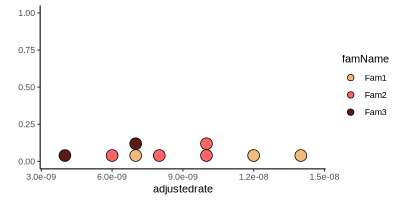

In [68]:
%%R -w 400 -h 200
library(wesanderson)
p = ggplot(adjusted,aes(x = adjustedrate, fill = famName)) +
    geom_dotplot(binwidth=1e-09, dotsize = 0.5,method = 'histodot',stackgroups = TRUE) + 
    scale_fill_manual(values = wes_palette('GrandBudapest1')) + 
    ylab('') +
    theme_classic()
print(p)
ggsave('mutation_figs/sample_values.pdf',width = 3, height = 1)

In [150]:
cmd = f"vcftools --gzvcf vcfs/biallelic.vcf.gz --het --stdout > samples_vcftools.het"
print(cmd)

# Mutation spectra

# A tibble: 6 × 2
  label count
  <chr> <int>
1 C>A      17
2 C>G      19
3 C>T      38
4 T>A      17
5 T>C      26
6 T>G       9


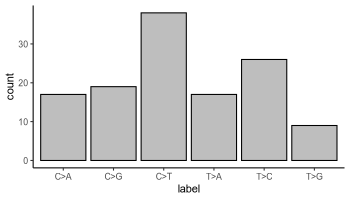

In [92]:
%%R -w 350 -h 200
results = fread('final/all_sample_by_candidates.txt') %>% set_colnames(c('sample','chrom','start','pos','ref','alt'))

results %<>% 
    mutate(mut_type = paste0(ref,'>',alt)) %>%
    group_by(mut_type) %>%
    count() %>%
    ungroup #%>%
   # mutate(RC = gsub('^A>','',mut_type))


condensed_spectra = data.frame(label = c('C>A','C>G','C>T','T>A','T>C','T>G'), 
                               forward = c('C>A','C>G','C>T','T>A','T>C','T>G'), 
                               reverse = c('G>T','G>C','G>A','A>T','A>G','A>C'))

mut_summary = 
left_join(results, condensed_spectra, by = c('mut_type' = 'forward')) %>% 
left_join(.,condensed_spectra,by = c ('mut_type' = 'reverse')) %>%
mutate(label = coalesce(label.x,label.y)) %>%
    dplyr::select(mut_type, label, n) %>%
    group_by(label) %>%
    summarize(count = sum(n))

print(mut_summary)

ggplot(mut_summary) +
    geom_bar(aes(x = label, y = count), stat = 'identity', fill = 'gray', color = 'black') +
    theme_classic()

How many C->T sites are in CpG sites


In [75]:
%%bash
# Positive strand
awk '{OFS=""} ($5 == "C" && $6 == "T") {print $2,":",$4,"-",$4+1}' final/all_sample_by_candidates.txt | while read REGION;do samtools faidx --mark-strand sign white_abalone.fasta ${REGION};done | grep -i -B 1 "cg" | grep ">"
# Negative strand 
awk '{OFS=""} ($5 == "G" && $6 == "A") {print $2,":",$4-1,"-",$4}' final/all_sample_by_candidates.txt | while read REGION;do samtools faidx --mark-strand sign --reverse-complement white_abalone.fasta ${REGION};done | grep -i -B 1 "cg" | grep ">"

>HiC_scaffold_11:5666174-5666175(+)
>HiC_scaffold_9:25871203-25871204(+)
>HiC_scaffold_4:3018728-3018729(+)
>HiC_scaffold_2:71549310-71549311(-)
>HiC_scaffold_15:10189581-10189582(-)
>HiC_scaffold_10:16544715-16544716(-)
>HiC_scaffold_13:16568119-16568120(-)
>HiC_scaffold_12:28098443-28098444(-)
>HiC_scaffold_4:37670769-37670770(-)
>HiC_scaffold_7:49030321-49030322(-)


10 are CpG > TpG

# A tibble: 7 × 3
  label   count type 
  <chr>   <dbl> <chr>
1 C>A        17 norm 
2 C>G        19 norm 
3 C>T        28 norm 
4 T>A        17 norm 
5 T>C        26 norm 
6 T>G         9 norm 
7 CpG>TpG    10 CpG  


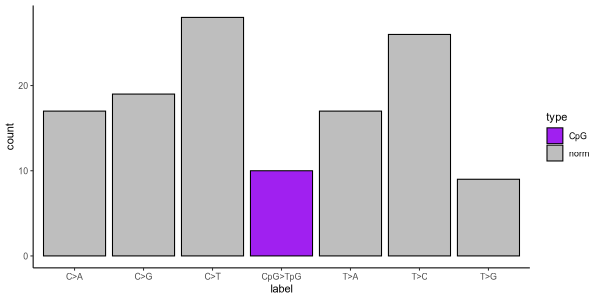

In [91]:
%%R -w 600 -h 300

mut_summary %<>%
    mutate(count = ifelse(label == 'C>T',count - 10,count), type = "norm") %>%
    bind_rows(., data.frame(label = c('CpG>TpG'), count = c(10), type = c('CpG')))
mut_summary %>% print
ggplot(mut_summary) +
        geom_bar(aes(x = label, y = count, fill = type), stat = 'identity', color = 'black') +
        scale_fill_manual(values = c('purple','gray')) +
        theme_classic()

## SFS from wild samples

Get the fine-grained MAF. The vcfs of the wild-caught individuals were generated in the notebook labelled `Diversity.ipynb`

In [48]:
cutoffs = [x / 100 for x in range(0, 100, 5)]
chroms = []
with open('white_abalone.fasta.fai','r') as infile:
    for line in infile:
        chrom, size, total, b, c = line.split('\t')
        if int(size) > 1e6:
            chroms.append(chrom)
infile.close()

for CHROM in chroms:
    for X in cutoffs:
        lower = X
        upper = X + 0.05
        cmd = ('''bcftools view -i 'F_MISSING<0.1' -m2 -M2 -v snps -f .,PASS  '''
               '''-q {lower} -Q {upper}  '''
               '''wild/vcfs/{CHROM}.allsites.filtered.vcf.gz '''
               ''' | grep -v "#" | awk '{{print $1,$2,$4,$5}}' '''
               '''> wild/{CHROM}_lowmiss_mutation_sample_{lower}_{upper}.txt''').format(lower = lower, upper = upper, CHROM = CHROM)
        slurm = make_slurm(run = False, id = f"{lower}_freq", cmd_string = cmd, time = '00:15:00', mem = '1000', p = 'short')

Some hacky code to do the same for CpGs

In [53]:
cutoffs = [x / 100 for x in range(0, 100, 5)]
for X in cutoffs:
    lower = X
    upper = X + 0.05
    cmd = ('''
cat wild/HiC*{lower}_{upper}.txt > wild/all_{lower}_{upper}.txt
FILE="wild/all_{lower}_{upper}.txt"

FWD_COUNT=$(awk '{{OFS=""}} ($3 == "C" && $4 == "T") {{print $1,":",$2,"-",$2+1}}' $FILE | while read REGION;do samtools faidx --mark-strand sign white_abalone.fasta ${{REGION}};done | grep -i -B 1 "cg" | grep ">" | wc -l | cut -d' ' -f1)
echo -e "{lower} {upper} FWD ${{FWD_COUNT}}" > wild/{lower}_{upper}_cpgs.txt

REV_COUNT=$(awk '{{OFS=""}} ($3 == "G" && $4 == "A") {{print $1,":",$2-1,"-",$2}}' $FILE | while read REGION;do samtools faidx --mark-strand sign --reverse-complement white_abalone.fasta ${{REGION}};done | grep -i -B 1 "cg" | grep ">" | wc -l | cut -d' ' -f1)
echo -e "{lower} {upper} REV ${{REV_COUNT}}" >> wild/{lower}_{upper}_cpgs.txt
    ''').format(lower = lower, upper = upper)
    slurm = make_slurm(run = False, id = f"{lower}_{upper}", cmd_string = cmd, mem = '10000', time = '24:00:00', p = 'long')

Summarize and plot

In [51]:
%%R -w 500 -h 200
condensed_spectra = data.frame(label = c('C>A','C>G','C>T','T>A','T>C','T>G'), 
                               forward = c('C>A','C>G','C>T','T>A','T>C','T>G'), 
                               reverse = c('G>T','G>C','G>A','A>T','A>G','A>C'))

fs = list.files('wild/',pattern = 'lowmiss',full.names = TRUE)
wild = bind_rows(lapply(fs, function(PATH){fread(PATH) %>% set_colnames(c('chrom','pos','ref','alt')) %>% mutate(path = basename(PATH))}))
wild %<>% 
    mutate(lower = gsub('.*_lowmiss_mutation_sample_','',path) %>% gsub('_.*','',.)) %>%
    mutate(lower = as.numeric(lower), upper = lower + 0.05)
wild %<>% 
    mutate(mut_type = paste0(ref,'>',alt)) %>%
    group_by(mut_type,lower) %>%
    count() %>%
    ungroup


##
counts_per_maf =
    wild %>%
    group_by(lower) %>%
    summarize(totalcount = sum(n)) %>%
    ungroup


##
fs = list.files('wild/',pattern = 'cpgs',full.names = TRUE)
CT_CpG = bind_rows(lapply(fs,function(PATH){fread(PATH) %>% set_colnames(c('lower','upper','dir','count'))}))
CT_CpG %<>% 
    group_by(lower) %>%
    summarize(count = sum(count)) %>%
    ungroup %>%
    mutate(label = 'CpG>TpG',TiTv = 'Ti')


###
wild_summary = 
    left_join(wild, condensed_spectra, by = c('mut_type' = 'forward')) %>% 
    left_join(.,condensed_spectra,by = c ('mut_type' = 'reverse')) %>%
    mutate(label = coalesce(label.x,label.y)) %>%
    dplyr::select(mut_type, lower, label, n) %>%
    group_by(label,lower) %>%
    summarize(count = sum(n)) %>%
    left_join(., condensed_spectra, by = c('label')) #%>%

nonCT = 
    wild_summary %>% filter(!label == 'C>T')
CT = 
    wild_summary %>% filter(label == 'C>T') %>%
    left_join(.,CT_CpG, by = c('lower')) %>%
    mutate(adjusted = count.x - count.y) %>%
    dplyr::select(label.x, lower, adjusted, forward, reverse, TiTv.x) %>%
    set_colnames(c('label','lower','count','forward','reverse','TiTv'))


final = 
    bind_rows(list(nonCT,CT,CT_CpG)) %>%
    left_join(., counts_per_maf) %>%
    mutate(pct = count/totalcount)

ggplot(final, aes(x = lower + 0.05, y = pct, color = label)) +
    geom_point(size = 4, alpha = 0.8, pch = 20) +
    xlab("MAF upper bound [X - 0.05, X)") +
    ylab("Pct. of SNPs in wild individuals") +
    scale_color_npg() +

    #ggtitle('SNP spectra by 0.05 bin widths') +
    geom_line() +
    theme_classic() +
    ylim(c(0,0.40)) +
    scale_x_continuous(limits = c(0, 1), breaks = seq(0, 1, by = 0.05)) 

Error in `group_by()`:
! Must group by variables found in `.data`.
✖ Column `lower` is not found.
Run `rlang::last_trace()` to see where the error occurred.

Error in group_by(., lower) : 
✖ Column `lower` is not found.


RInterpreterError: Failed to parse and evaluate line "condensed_spectra = data.frame(label = c('C>A','C>G','C>T','T>A','T>C','T>G'), \n                               forward = c('C>A','C>G','C>T','T>A','T>C','T>G'), \n                               reverse = c('G>T','G>C','G>A','A>T','A>G','A>C'))\n\nfs = list.files('wild/',pattern = 'lowmiss',full.names = TRUE)\nwild = bind_rows(lapply(fs, function(PATH){fread(PATH) %>% set_colnames(c('chrom','pos','ref','alt')) %>% mutate(path = basename(PATH))}))\nwild %<>% \n    mutate(lower = gsub('.*_lowmiss_mutation_sample_','',path) %>% gsub('_.*','',.)) %>%\n    mutate(lower = as.numeric(lower), upper = lower + 0.05)\nwild %<>% \n    mutate(mut_type = paste0(ref,'>',alt)) %>%\n    group_by(mut_type,lower) %>%\n    count() %>%\n    ungroup\n\n\n##\ncounts_per_maf =\n    wild %>%\n    group_by(lower) %>%\n    summarize(totalcount = sum(n)) %>%\n    ungroup\n\n\n##\nfs = list.files('wild/',pattern = 'cpgs',full.names = TRUE)\nCT_CpG = bind_rows(lapply(fs,function(PATH){fread(PATH) %>% set_colnames(c('lower','upper','dir','count'))}))\nCT_CpG %<>% \n    group_by(lower) %>%\n    summarize(count = sum(count)) %>%\n    ungroup %>%\n    mutate(label = 'CpG>TpG',TiTv = 'Ti')\n\n\n###\nwild_summary = \n    left_join(wild, condensed_spectra, by = c('mut_type' = 'forward')) %>% \n    left_join(.,condensed_spectra,by = c ('mut_type' = 'reverse')) %>%\n    mutate(label = coalesce(label.x,label.y)) %>%\n    dplyr::select(mut_type, lower, label, n) %>%\n    group_by(label,lower) %>%\n    summarize(count = sum(n)) %>%\n    left_join(., condensed_spectra, by = c('label')) #%>%\n\nnonCT = \n    wild_summary %>% filter(!label == 'C>T')\nCT = \n    wild_summary %>% filter(label == 'C>T') %>%\n    left_join(.,CT_CpG, by = c('lower')) %>%\n    mutate(adjusted = count.x - count.y) %>%\n    dplyr::select(label.x, lower, adjusted, forward, reverse, TiTv.x) %>%\n    set_colnames(c('label','lower','count','forward','reverse','TiTv'))\n\n\nfinal = \n    bind_rows(list(nonCT,CT,CT_CpG)) %>%\n    left_join(., counts_per_maf) %>%\n    mutate(pct = count/totalcount)\n\nhead(final)\n".
R error message: 'Error in group_by(., lower) : \n✖ Column `lower` is not found.'

## Fig. 2

In [336]:
%%R -w 800 -h 300
library(wesanderson)
library(ggsci)
### PROCESSING PEDIGREE SPECTRA
results = fread('final/all_sample_by_candidates.txt') %>% 
    set_colnames(c('sample','chrom','start','pos','ref','alt')) %>%
    dplyr::select(chrom,pos,ref,alt) %>%
    distinct

results %<>% 
    mutate(mut_type = paste0(ref,'>',alt)) %>%
    group_by(mut_type) %>%
    count() %>%
    ungroup

condensed_spectra = data.frame(label = c('C>A','C>G','C>T','T>A','T>C','T>G'), 
                               forward = c('C>A','C>G','C>T','T>A','T>C','T>G'), 
                               reverse = c('G>T','G>C','G>A','A>T','A>G','A>C'),
                               TiTv = c('Tv','Tv','Ti','Tv','Ti','Tv'))


mut_summary = 
left_join(results, condensed_spectra, by = c('mut_type' = 'forward')) %>% 
left_join(.,condensed_spectra,by = c ('mut_type' = 'reverse')) %>%
mutate(label = coalesce(label.x,label.y)) %>%
    dplyr::select(mut_type, label, n) %>%
    group_by(label) %>%
    summarize(count = sum(n)) %>%
    left_join(., condensed_spectra, by = c('label')) %>%
    mutate(count = ifelse(label == 'C>T',count - 10,count), type = "norm") %>%
    bind_rows(., data.frame(label = c('CpG>TpG'), count = c(10), type = c('CpG'))) %>%
    mutate(dummy = "A") %>%
    mutate(pct = count/sum(count), source = 'mut')


    

left = 
    ggplot(mut_summary,aes(x = dummy, y = pct, color = label)) +
    geom_jitter(width = 0, height = 0.01, size = 4, alpha = 0.8, pch = 20) +
    geom_line() +
    scale_color_npg() +
    ylab("Pct. of DNMs in pedigrees") +
    xlab("") +
    theme_classic() + 
    theme(legend.position = 'none') +
    ylim(c(0,0.40))

right = 
    ggplot(final,aes(x = lower + 0.05, y = pct, color = label)) +
    geom_point(size = 4, alpha = 0.8, pch = 20) +
    xlab("MAF upper bound [X - 0.05, X)") +
    ylab("Pct. of SNPs in wild individuals") +
    scale_color_npg() +

    #ggtitle('SNP spectra by 0.05 bin widths') +
    geom_line() +
    theme_classic() +
    ylim(c(0,0.40)) +
    scale_x_continuous(limits = c(0, 1), breaks = seq(0, 1, by = 0.05)) 

p = left + right + plot_layout(widths = c(1,5))
#pdf('./mutation_figs/maf_spectra.svg',width = 8, height = 3)
print(p)
#dev.off()

`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?
png 
  2 


# Other species

Most data from: https://academic.oup.com/evlett/article/7/4/216/7202139#411808538

In [31]:
%%R
library(readxl)
data = read_excel('mutation_literature/mutation_rate_literature_updating3.xlsx', sheet = 1)
snp_rates = 
    data %>% 
    #filter(Group != 'Unicellular') %>%
    filter(TYPE == 'snp') %>%
    filter(reproduction == 'sexual') %>%
    mutate(u_mean = as.numeric(u_mean))
snp_rates %>%
    filter(!Group %in% c('unicellular', 'plants','fungus')) %>%
    #filter(Group %in% c('birds','mammals','primates','human','fish','reptiles')) %>%
    dplyr::select(Species) %>%
    distinct

# A tibble: 102 × 1
   Species                 
   <chr>                   
 1 Drosophila pseudoobscura
 2 Chironomus riparius     
 3 Anopheles gambiae       
 4 Anopheles coluzzii      
 5 Anopheles stephensi     
 6 Drosophila melanogaster 
 7 Drosophila simulans     
 8 Bombyx mori             
 9 Heliconius melpomene    
10 Apis mellifera          
# ℹ 92 more rows
# ℹ Use `print(n = ...)` to see more rows


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


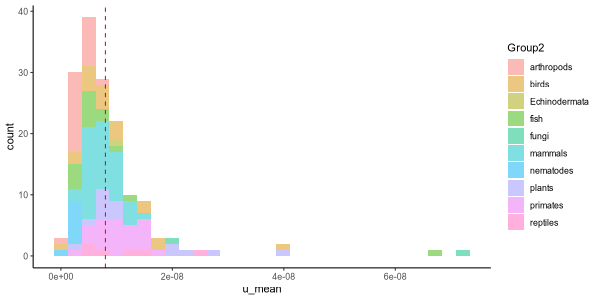

In [32]:
%%R -w 600 -h 300
snp_rates = 
    data %>% 
    #filter(Group != 'Unicellular') %>%
    filter(TYPE == 'snp') %>%
    filter(reproduction == 'sexual') %>%
    mutate(u_mean = as.numeric(u_mean))
    
ggplot(snp_rates %>% filter(!Group %in% c('human','unicellular'))) + 
    geom_histogram(aes(x = u_mean, fill = Group2), alpha = 0.5) +
    geom_vline(aes(xintercept = 7.99e-09),lty =2, col = 'red') +
    theme_classic()
    

## Broadcast spawners

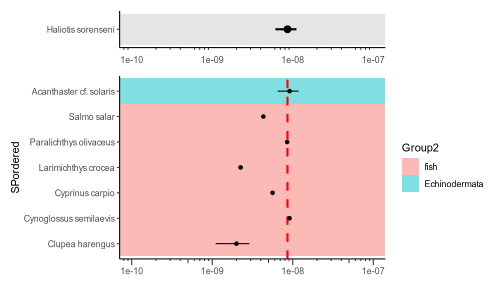

In [35]:
%%R -w 500 -h 300
snp_rates = 
    data %>% 
    #filter(Group != 'Unicellular') %>%
    filter(TYPE == 'snp') %>%
    filter(reproduction == 'sexual') %>%
    mutate(u_mean = as.numeric(u_mean))

inp = 
    snp_rates %>% 
    filter(!Group %in% c('human','unicellular')) %>% 
    filter(!Species %in% c('Amphilophus','Marasmius oreades')) %>%
    group_by(Species) %>% 
    mutate(idx = seq(1,n(),1)) %>% 
    ungroup  %>% 
    mutate(Group2 = ifelse(Group2 == 'primates','mammals',Group2)) %>%
    mutate(Group2 = fct_relevel(Group2,c('primates','mammals','birds','reptiles','fish','Echinodermata','arthropods','nematodes','fungi','plants'))) %>%
    mutate(SPordered = fct_reorder(Species,as.numeric(Group2)))  %>%
    filter(Broadcast == 'Y')

lower = 1e-10
upper = 1e-07

a = 
    ggplot() +
    geom_tile(aes(x = 8.60e-09, width = Inf, y="Haliotis sorenseni"), alpha = 0.1, fill = 'black') +
    geom_point(aes(x = 8.60e-09, y = "Haliotis sorenseni"), size = 3) +
    geom_segment(aes(x = 6.096043e-09,xend = 1.111221e-08, y = 'Haliotis sorenseni'), size = 1) + 
    ylab("") +
    theme_classic() +
    theme(axis.title.x = element_blank(), axis.ticks.x = element_blank(), panel.grid.major = element_blank(),panel.grid.minor = element_blank()) +
    #coord_cartesian(xlim = c(lower,upper)) +
    #coord_trans(x = "log10",xlim = c(lower,upper)) +
    scale_x_log10(guide = "axis_logticks", limits = c(lower,upper))

b = 
    ggplot() + 
    geom_tile(data = inp %>% dplyr::select(SPordered,Group2) %>% distinct, aes(x = 1e-09, width = Inf, y=SPordered,fill=Group2), alpha = 0.5) +
    geom_vline(aes(xintercept = 8.60e-09),lty = 2, col = 'red', size = 1) +    
    geom_point(data = inp, aes(x = as.numeric(u_mean), y = SPordered, group = Species)) + 
    geom_segment(data = inp, aes(x = as.numeric(u_lower),xend = as.numeric(u_upper), y = SPordered)) + 
    xlab("") +
    theme_classic() +
    #scale_x_continuous(sec.axis = dup_axis()) +
    #coord_cartesian(xlim = c(lower,upper))
    #coord_trans(x = "log10", xlim = c(lower,upper)) 
    scale_x_log10(guide = "axis_logticks", limits = c(lower,upper))

library(patchwork)
a/b + plot_layout(heights = c(0.2,1))

## **Fig. 1** (With tree)

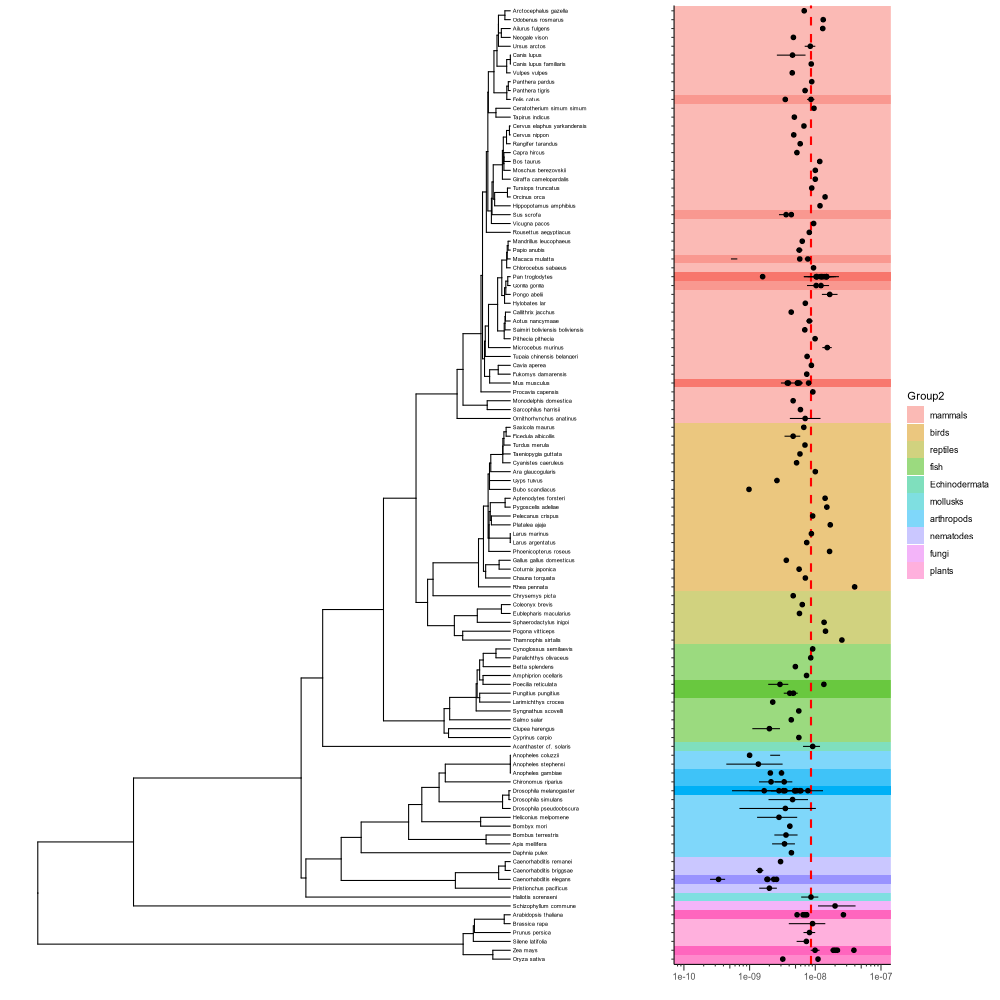

In [37]:
%%R -w 1000 -h 1000

snp_rates = 
    data %>% 
    #filter(Group != 'Unicellular') %>%
    filter(TYPE == 'snp') %>%
    filter(reproduction == 'sexual') %>%
    mutate(u_mean = as.numeric(u_mean))
snp_rates = bind_rows(snp_rates, data.frame(Group2 = 'mollusks', Species = "Haliotis sorenseni", u_mean = 8.60e-09, u_lower = '6.096043e-09', u_upper = '1.111221e-08'))

inp = 
    snp_rates %>% 
    filter(!Group %in% c('human','unicellular')) %>% 
    filter(!Species %in% c('Amphilophus','Marasmius oreades')) %>%
    group_by(Species) %>% 
    mutate(rep = as.character(seq(1,n(),1))) %>% 
    ungroup  %>% 
    mutate(Group2 = ifelse(Group2 == 'primates','mammals',Group2)) %>%
    mutate(Group2 = fct_relevel(Group2,c('primates','mammals','birds','reptiles','fish','Echinodermata','mollusks','arthropods','nematodes','fungi','plants'))) %>%
    mutate(SPordered = fct_reorder(Species,as.numeric(Group2)))
    
    
#fwrite(inp %>% dplyr::select(Species) %>% distinct,'misc/species.txt',col.names=F)



lower = 1e-10
upper = 1e-07

b = 
    ggplot(data = inp %>% mutate(Species = gsub(" ","_",Species)), aes(x = as.numeric(u_mean), y = Species)) + 
    geom_point() +    
    geom_tile(aes(x = 1e-09, width = Inf, y=Species,fill=Group2), alpha = 0.5) +
    #scale_alpha(range = c(0.5,0.5)) +
    geom_vline(aes(xintercept = 8.60e-09),lty = 2, col = 'red', size = 1) +
    geom_point(size = 2) +
    geom_segment(aes(x = as.numeric(u_lower),xend = as.numeric(u_upper), y = Species)) + 
    xlab("") +
    ylab("") + 
    theme_classic() + 
    theme(axis.text.y = element_blank()) + 
    #scale_x_continuous(sec.axis = dup_axis()) +
    #coord_cartesian(xlim = c(lower,upper))
    #coord_trans(x = "log10", xlim = c(lower,upper)) 
    scale_x_log10(guide = "axis_logticks", limits = c(lower,upper))

#b
library(ggtree)
library(aplot)
nwk = read.tree('misc/timetree_mut_species_edited.nwk')

p = 
    ggtree(nwk) +
    geom_tiplab(size = 2) +
    xlim(c(0,2000))

c = b %>% insert_left(p,3)
c$plotlist[[2]]$data$label  = sapply(c$plotlist[[2]]$data$label,function(STRING){gsub("_"," ",STRING)})


#pdf('mutation_figs/tree_rates.pdf',width = 7, height = 7)
print(c)
#dev.off()

## Life history supp. figure

In [146]:
%%R -w 800 -h 800
library(patchwork)
lh = read_excel('bergeron_supplement.xlsx',sheet = 9, skip = 1)
a = ggplot(lh) +
    geom_point(aes(x = `Generation time (years)`, y = `Modeled rate per generation (m_generation_modeled)`), size = 3, shape = 19 ) +
    geom_point(aes(x = 6, y = 8.60e-9), size = 3, color = 'red') +
    xlab('Generation time') +
    ylab('Mutation rate per site per generation') +
    theme_classic() 

b = ggplot(lh) +
    geom_point(aes(x = `Average maturation time`, y = `Modeled rate per generation (m_generation_modeled)`), size = 3, shape = 19) +
    geom_point(aes(x = 4, y = 8.60e-9), size = 3, color = 'red') +
    xlab('Age at sexual maturity') +
    ylab('Mutation rate per site per generation') +
    theme_classic() 

c = ggplot(lh) +
    geom_point(aes(x = `Lifespan in the wild (years)`, y = `Modeled rate per generation (m_generation_modeled)`), size = 3, shape = 19) +
    geom_point(aes(x = 20, y = 8.60e-9), size = 3, color = 'red') +
    xlab('Lifespan in the wild') +
    ylab('Mutation rate per site per generation') +
    theme_classic() 

# Harmonic mean sorenseni is 52124
d = ggplot(lh) +
    geom_point(aes(x = log10(as.numeric(`Ne (harmonic mean, psmc)`)), y = `Modeled rate per generation (m_generation_modeled)`), size = 3, shape = 19) +
    geom_point(aes(x = log10(52124), y = 8.60e-9), size = 3, color = 'red') +
    xlab('Log10 Ne') +
    ylab('Mutation rate per site per generation') +
    theme_classic() 


(a + b) / (c + d)
ggsave('mutation_figs/lh_supp.pdf',width = 7, height = 6)
